# Imports

In [40]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Data Prep


In [41]:
data = pd.read_csv('../TrainDataset2024.csv', index_col=0)

#MISSING DATA
data.replace(999, np.nan, inplace=True)

imputer = SimpleImputer(strategy='median')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns,index=data.index)


target = data[['pCR (outcome)']]#'RelapseFreeSurvival (outcome)']]
data.drop(columns=['pCR (outcome)','RelapseFreeSurvival (outcome)'], axis=1, inplace=True)

key_features = data[['ER', 'HER2', 'Gene']]
data.drop(columns=['ER', 'HER2', 'Gene'], axis=1, inplace=True)


In [42]:

#NORMALISATION
normalizer = Normalizer()
vector_normalized_data = normalizer.fit_transform(data)


In [43]:

#FEATURE REDUCTION
pca = PCA(n_components=0.95)
data_reduced = pca.fit_transform(vector_normalized_data)

pca_complete = pd.DataFrame(data_reduced, index=data.index)
pca_complete = pd.concat([pca_complete, key_features], axis=1)


# Training Data

In [44]:
param_grid = {
    'C': [0.1, 1, 10], 
    'gamma': [0.001, 0.01, 0.1], 
    'kernel': ['rbf', 'linear'] 
}

#CHANGE ME
model = SVC(class_weight='balanced')


In [45]:
n_folds = 4

def train_model(data):
    # Outer K-fold cross-validation
    outer_cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    data = data.rename(str,axis="columns") 
    
    # Perform nested cross-validation
    outer_results = []
    for train_idx, test_idx in outer_cv.split(data, target):
        # Split data
        X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
        y_train, y_test = np.ravel(target.iloc[train_idx]), np.ravel(target.iloc[test_idx])

        # Inner loop: Hyperparameter tuning using GridSearchCV
        inner_cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv)
        grid_search.fit(X_train, y_train)

        # Evaluate on the test set
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        # Collect results
        outer_results.append({
            "best_params": grid_search.best_params_,
            "classification_report": classification_report(y_test, y_pred, output_dict=True, zero_division=0),
            "accuracy": best_model.score(X_test, y_test)
        })

    # Print the results for each fold
    for i, result in enumerate(outer_results, 1):
        print(f"Fold {i}")
        print(f"Best Parameters: {result['best_params']}")
        print("Classification Report:")
        print(classification_report(
            y_test, y_pred, target_names=['0.0', '1.0'], zero_division=0
        ))
        print(f"Accuracy: {result['accuracy']:.4f}")
        print("-" * 40)

    # Overall results
    mean_accuracy = sum(res["accuracy"] for res in outer_results) / len(outer_results)
    print(f"Mean Accuracy: {mean_accuracy:.4f}")


In [46]:
train_model(pca_complete)

Fold 1
Best Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86        80
         1.0       0.48      0.65      0.55        20

    accuracy                           0.79       100
   macro avg       0.69      0.74      0.71       100
weighted avg       0.82      0.79      0.80       100

Accuracy: 0.7600
----------------------------------------
Fold 2
Best Parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86        80
         1.0       0.48      0.65      0.55        20

    accuracy                           0.79       100
   macro avg       0.69      0.74      0.71       100
weighted avg       0.82      0.79      0.80       100

Accuracy: 0.2300
----------------------------------------
Fold 3
Best Parameters: {'C': 0.1, 'gamma': 0.1, 'k

# Re-Train Single Final Model on entire dataset using best-performing hyperparameters

In [47]:
model = SVC(class_weight='balanced',kernel='rbf', C=1, gamma=0.01)

def train_model_single(data):

    data = data.rename(str,axis="columns") 
    
    # Split data into 80% training and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    # Train the model on the training data
    model.fit(X_train, np.ravel(y_train))

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_prob = model.decision_function(X_test)

    # Print the results
    print("Classification Report:")
    print(classification_report(np.ravel(y_test), y_pred, target_names=['0.0', '1.0'], zero_division=0))
    print(f"Accuracy: {model.score(X_test, y_test):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0.0', '1.0'], yticklabels=['0.0', '1.0'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.78      0.83        64
         1.0       0.42      0.62      0.50        16

    accuracy                           0.75        80
   macro avg       0.65      0.70      0.67        80
weighted avg       0.80      0.75      0.77        80

Accuracy: 0.7500


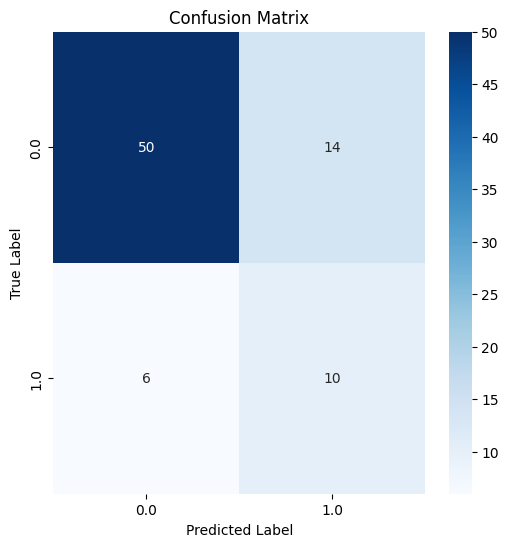

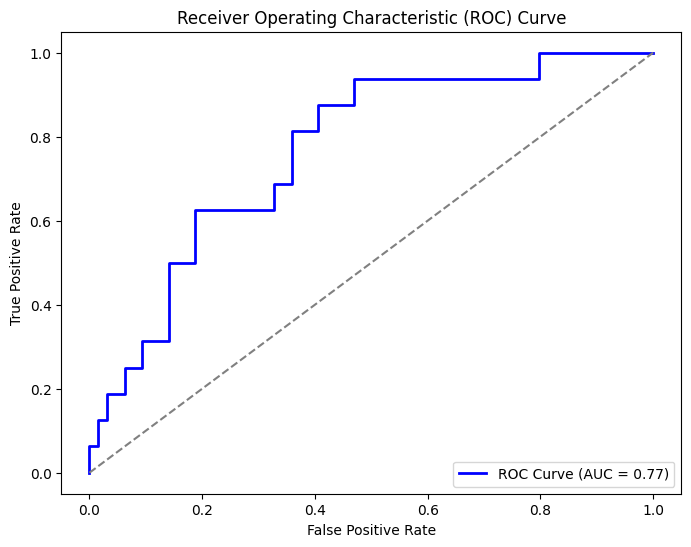

In [48]:
train_model_single(pca_complete)